# An RNN for short-term predictions
This model will try to predict the next value in a short sequence based on historical data. This can be used for example to forecast demand based on a couple of weeks of sales data.

In [20]:
# using Tensorflow 2
%tensorflow_version 2.x
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 2.0.0


In [0]:
#@title Display utilities [RUN ME]

from enum import IntEnum
import numpy as np

class Waveforms(IntEnum):
    SINE1 = 0
    SINE2 = 1
    SINE3 = 2
    SINE4 = 3

def create_time_series(waveform, datalen):
    # Generates a sequence of length datalen
    # There are three available waveforms in the Waveforms enum
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55), (0.4, 0.25)]
    freq1, freq2 = frequencies[waveform]
    noise = [np.random.random()*0.2 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

from matplotlib import transforms as plttrans

plt.rcParams['figure.figsize']=(16.8,6.0)
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=0
plt.rcParams['grid.color']='#DDDDDD'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['xtick.major.size']=0
plt.rcParams['ytick.major.size']=0

def picture_this_1(data, datalen):
    plt.subplot(211)
    plt.plot(data[datalen-512:datalen+512])
    plt.axvspan(0, 512, color='black', alpha=0.06)
    plt.axvspan(512, 1024, color='grey', alpha=0.04)
    plt.subplot(212)
    plt.plot(data[3*datalen-512:3*datalen+512])
    plt.axvspan(0, 512, color='grey', alpha=0.04)
    plt.axvspan(512, 1024, color='black', alpha=0.06)
    plt.show()
    
def picture_this_2(data, batchsize, seqlen):
    samples = np.reshape(data, [-1, batchsize, seqlen])
    rndsample = samples[np.random.choice(samples.shape[0], 8, replace=False)]
    print("Tensor shape of a batch of training sequences: " + str(rndsample[0].shape))
    print("Random excerpt:")
    subplot = 241
    for i in range(8):
        plt.subplot(subplot)
        plt.plot(rndsample[i, 0]) # first sequence in random batch
        subplot += 1
    plt.show()
    
def picture_this_3(predictions, evaldata, evallabels, seqlen):
    subplot = 241
    for i in range(8):
        plt.subplot(subplot)
        #k = int(np.random.rand() * evaldata.shape[0])
        l0, = plt.plot(evaldata[i, 1:], label="data")
        plt.plot([seqlen-2, seqlen-1], evallabels[i, -2:], ":")
        l1, = plt.plot([seqlen-1], [predictions[i]], "o", label='Predicted')
        l2, = plt.plot([seqlen-1], [evallabels[i][-1]], "o", label='Ground Truth')
        if i==0:
            plt.legend(handles=[l0, l1, l2])
        subplot += 1
    plt.show()
    
def histogram_helper(data, title, last_label=None):
  labels = ['RND', 'LAST', 'LAST2', 'LINEAR', 'DNN', 'CNN', 'RNN', 'RNN_N']
  colors = ['#4285f4', '#34a853', '#fbbc05', '#ea4334',
            '#4285f4', '#34a853', '#fbbc05', '#ea4334',
            '#4285f4', '#34a853', '#fbbc05', '#ea4334']
  fig = plt.figure(figsize=(7,4))
  plt.xticks(rotation='40')
  ymax = data[1]*1.3
  plt.ylim(0, ymax)
  plt.title(title, pad="20")
  # remove data points where data is None
  filtered = filter(lambda tup: tup[1] is not None, zip(labels, data, colors))
  # split back into lists
  labels, data, colors = map(list, zip(*filtered))
  # replace last label is appropriate
  if last_label is not None:
    labels[-1] = last_label
  # histogram plot
  plt.bar(labels, data, color=colors)
  # add values on histogram bars
  for i, (_, v, color) in enumerate(zip(labels, data, colors)):
      plt.gca().text(i-0.3, min(v, ymax)+0.02, "{0:.4f}".format(v), color=color, fontweight="bold")
  plt.show()

def picture_this_hist_yours(data):
  histogram_helper(data, 'RMSE: your model vs. other approaches',
                   last_label='Yours')

def picture_this_hist_all(data):
  histogram_helper(data, 'RMSE: final comparison')

## Generate fake dataset

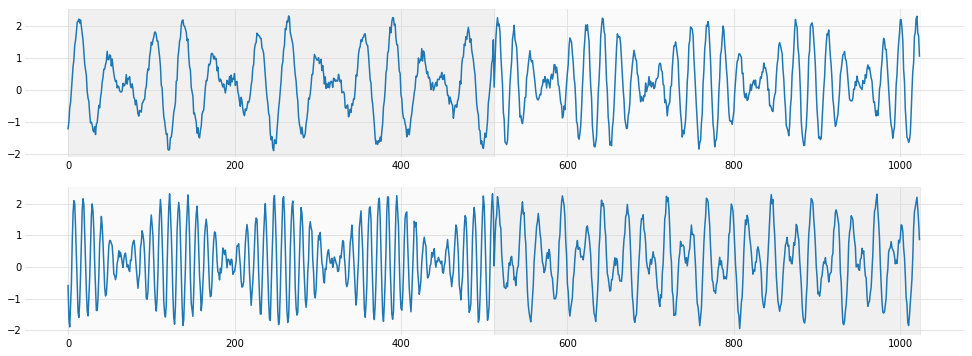

In [0]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([create_time_series(waveform, DATA_SEQ_LEN) for waveform in Waveforms]) # 4 different wave forms
picture_this_1(data, DATA_SEQ_LEN)
DATA_LEN = DATA_SEQ_LEN * 4 # since we concatenated 4 sequences

## Hyperparameters

In [0]:
RNN_CELLSIZE = 32   # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
LAST_N = SEQLEN//2  # loss computed on last N element of sequence in advanced RNN model

## Visualize training sequences
This is what the neural network will see during training.

In [0]:
picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## Prepare datasets

In [0]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)

# cut data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# make an evaluation dataset by cutting the sequences differently
evaldata = np.roll(data, -SEQLEN//2)
evallabels = np.roll(evaldata, -1)
evaldata = np.reshape(evaldata, [-1, SEQLEN])
evallabels = np.reshape(evallabels, [-1, SEQLEN])

def get_training_dataset(last_n=1):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          traindata, # features
          labeldata[:,-last_n:SEQLEN] # targets: the last element or last n elements in the shifted sequence
      )
  )
  # Dataset API used here to put the dataset into shape
  dataset = dataset.repeat()
  dataset = dataset.shuffle(DATA_LEN//SEQLEN) # shuffling is important ! (Number of sequences in shuffle buffer: all of them)
  dataset = dataset.batch(BATCHSIZE, drop_remainder = True)
  return dataset

def get_evaluation_dataset(last_n=1):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          evaldata, # features       
          evallabels[:,-last_n:SEQLEN] # targets: the last element or last n elements in the shifted sequence
      )
  )
  # Dataset API used here to put the dataset into shape
  dataset = dataset.batch(evaldata.shape[0], drop_remainder = True) # just one batch with everything
  return dataset

### Peek at the data

In [0]:
train_ds = get_training_dataset()
for features, labels in train_ds.take(10):
  print("input_shape:", features.numpy().shape, ", shape of labels:", labels.numpy().shape)

## Benchmark models
We will compare the RNNs against these models. For the time being you can regard them as black boxes.

In [0]:
# this is how to create a Keras model from neural network layers
def compile_keras_sequential_model(list_of_layers, model_name):
  
    # a tf.keras.Sequential model is a sequence of layers
    model = tf.keras.Sequential(list_of_layers, name=model_name)    
    
    # to finalize the model, specify the loss, the optimizer and metrics
    model.compile(
       loss = 'mean_squared_error',
       optimizer = 'rmsprop',
       metrics = ['RootMeanSquaredError'])
    
    # this prints a description of the model
    model.summary()
    
    return model
  
#
# three very simplistic "models" that require no training. Can you beat them ?
#

# SIMPLISTIC BENCHMARK MODEL 1
predict_same_as_last_value = lambda x: x[:,-1] # shape of x is [BATCHSIZE,SEQLEN]
# SIMPLISTIC BENCHMARK MODEL 2
predict_trend_from_last_two_values = lambda x: x[:,-1] + (x[:,-1] - x[:,-2])
# SIMPLISTIC BENCHMARK MODEL 3
predict_random_value = lambda x: tf.random.uniform(tf.shape(x)[0:1], -2.0, 2.0)

def model_layers_from_lambda(lambda_fn, input_shape, output_shape):
  return [tf.keras.layers.Lambda(lambda_fn, input_shape=input_shape),
          tf.keras.layers.Reshape(output_shape)]

model_layers_RAND  = model_layers_from_lambda(predict_random_value,               input_shape=[SEQLEN,], output_shape=[1,])
model_layers_LAST  = model_layers_from_lambda(predict_same_as_last_value,         input_shape=[SEQLEN,], output_shape=[1,])
model_layers_LAST2 = model_layers_from_lambda(predict_trend_from_last_two_values, input_shape=[SEQLEN,], output_shape=[1,])

#
# three neural network models for comparison, in increasing order of complexity
#

# BENCHMARK MODEL 4: linear model (RMSE: 0.215 after 10 epochs)
model_layers_LINEAR = [tf.keras.layers.Dense(1, input_shape=[SEQLEN,])] # output shape [BATCHSIZE, 1]

# BENCHMARK MODEL 5: 2-layer dense model (RMSE: 0.197 after 10 epochs)
model_layers_DNN = [tf.keras.layers.Dense(SEQLEN//2, activation='relu', input_shape=[SEQLEN,]), # input  shape [BATCHSIZE, SEQLEN]
                    tf.keras.layers.Dense(1)] # output shape [BATCHSIZE, 1]

# BENCHMARK MODEL 6: convolutional (RMSE: 0.186 after 10 epochs)
model_layers_CNN = [
    tf.keras.layers.Reshape([SEQLEN, 1], input_shape=[SEQLEN,]), # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    tf.keras.layers.Conv1D(filters=8, kernel_size=4, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),  # [BATCHSIZE, SEQLEN//2, 8]
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding="same"),  # [BATCHSIZE, SEQLEN//2, 8]
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    tf.keras.layers.Conv1D(filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid"), # output shape [BATCHSIZE, 1, 1]
    tf.keras.layers.Reshape([1,]) ] # output shape [BATCHSIZE, 1]

# instantiate the benchmark models and train those that need training
steps_per_epoch = steps_per_epoch = DATA_LEN // SEQLEN // BATCHSIZE
NB_BENCHMARK_EPOCHS = 10
model_RAND   = compile_keras_sequential_model(model_layers_RAND, "RAND") # Simplistic model without parameters. It needs no training.
model_LAST   = compile_keras_sequential_model(model_layers_LAST, "LAST") # Simplistic model without parameters. It needs no training.
model_LAST2  = compile_keras_sequential_model(model_layers_LAST2, "LAST2") # Simplistic model without parameters. It needs no training.
model_LINEAR = compile_keras_sequential_model(model_layers_LINEAR, "LINEAR")
model_LINEAR.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=NB_BENCHMARK_EPOCHS)
model_DNN = compile_keras_sequential_model(model_layers_DNN, "DNN")
model_DNN.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=NB_BENCHMARK_EPOCHS)
model_CNN = compile_keras_sequential_model(model_layers_CNN, "CNN")
model_CNN.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=NB_BENCHMARK_EPOCHS)

# evaluate the benchmark models
benchmark_models = [model_RAND, model_LAST, model_LAST2, model_LINEAR, model_DNN, model_CNN]
benchmark_rmses = []
for model in benchmark_models:
  _, rmse = model.evaluate(get_evaluation_dataset(), steps=1)
  benchmark_rmses.append(rmse)

## RNN model [WORK REQUIRED]

1. Train the model as it is, with a single dense layer (i.e. a linear model). Execute the Evaluation and Prediction cells and compare to benchmark models.
 * How good is it ?
1. Implement an RNN model with a single layer GRU cell: [`tf.keras.layers.GRU(RNN_CELLSIZE)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)<br/>
 followed by a linear regression layer (readout): [`tf.keras.layers.Dense(1)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)<br/>
 Note down the shapes at each layer and adjust as necessary with [`tf.keras.layers.Reshape([…], input_shape=[…])`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape)<br/>
 Hints:
 * The first layer must have an `input_shape=[…]` parameter
 * tf.keras.layers.GRU implements an unrolled sequence of GRU cells. Its expected input shape is therefore [BATCHSIZE, SEQLEN, 1]
 * By default, tf.keras.layers.GRU only returns the last element in the output sequence. Its default output shape is [BATCHSIZE, RNN_CELLSIZE]
 * A dense layer with a single node has an output shape of [BATCHSIZE, 1]
 * Compare this with the shape of input and output data in the  "Peek at the data" cell above.
 * In Keras, tensor shapes have an implicit first dimension of BATCHSIZE. When you write input_shape=[SEQLEN,], the real shape is [BATCHSIZE, SEQLEN]
 * Pen, paper and fresh brain cells <font size="+2">🤯</font> strongly recommened. Have fun ! 

1. Now add a second layer of GRU cells. The first layer must feed it the entire output sequence.
 * The syntax for that is  [`tf.keras.layers.GRU(RNN_CELLSIZE, return_sequences=True)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
 * You can try three layers too but it will not perform significantly better.
1. Another option for RNNs is to compute the loss on the last N elements of the predicted sequence instead of the last 1.
 * Copy your RNN model and rename it model_RNN_N
 * Modify the last GRU layer to output the full sequence with  [`tf.keras.layers.GRU(RNN_CELLSIZE, return_sequences=True)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
 * The readout regression must now be replicated on all outputs in the sequence. The syntax for that is [`tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed)
 * Keep only the last N values in the sequence. This can be done with a lambda layer: [`tf.keras.layers.Lambda(lambda x: x[:,-LAST_N:SEQLEN,0])`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)
 * This model requires different target values during training and evaluation. Use get_training_dataset(last_n=LAST_N) and get_evaluation_dataset(last_n=LAST_N) to get them. Check shapes in the "Peek at the data" cell above.
 * A good value to try is LAST_N=SEQLEN//2. You can now train, evaluate, predict. Was is worth the extra effort <font size="+2">🤯</font>?
1. (Optional) In the "Benchmark" cell at the end of the notebook, copy-paste the layers of your RNN and RNN_N implementations and run the bechmark.
 
![deep RNN schematic](https://googlecloudplatform.github.io/tensorflow-without-a-phd/docs/images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
</div>

In [0]:
model_layers_RNN = [
    
    tf.keras.layers.Dense(1, input_shape=[SEQLEN,]) # input shape needed on first layer only
    #
    # TODO: Replace the dummy Dense layer with your own layers
    #
]

model_RNN = compile_keras_sequential_model(model_layers_RNN, "RNN")

## Training loop

In [0]:
# You can re-execute this cell to continue training

NB_EPOCHS = 3      # number of times the data is repeated during training
steps_per_epoch = DATA_LEN // SEQLEN // BATCHSIZE

model = model_RNN # model to train: model_LINEAR, model_DNN, model_CNN, model_RNN, model_RNN_N
train_ds = get_training_dataset() # use last_n=LAST_N for model_RNN_N

history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=NB_EPOCHS)

In [0]:
plt.plot(history.history['loss'])
plt.show()

## Evaluation

In [0]:
# Here "evaluating" using the training dataset
eval_ds = get_evaluation_dataset()  # use last_n=LAST_N for model_RNN_N
loss, your_rmse = model.evaluate(eval_ds, steps=1)

picture_this_hist_yours(benchmark_rmses + [your_rmse])

## Predictions

In [0]:
# execute multiple times to see different sample sequences
subset = np.random.choice(DATA_LEN//SEQLEN, 8) # pick 8 eval sequences at random

predictions = model.predict(evaldata[subset], steps=1) # prediction directly from numpy array
picture_this_3(predictions[:,-1], evaldata[subset], evallabels[subset], SEQLEN)

<a name="benchmark"></a>
## Benchmark
Benchmark all the algorithms.

In [0]:
your_RNN_layers = [
    #
    # copy-paste your RNN implementation here (layers only)
    #
]
assert len(your_RNN_layers)>0, "the model has no layers"
your_RNN_model = compile_keras_sequential_model(your_RNN_layers, 'RNN')

your_RNN_N_layers = [
    #
    # copy-paste your RNN_N implementation here (layers only)
    #
]
assert len(your_RNN_layers)>0, "the model has no layers"
your_RNN_N_model = compile_keras_sequential_model(your_RNN_N_layers, 'RNN_N')

# train your models from scratch
your_RNN_model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=NB_BENCHMARK_EPOCHS)
your_RNN_N_model.fit(get_training_dataset(last_n=LAST_N), steps_per_epoch=steps_per_epoch, epochs=NB_BENCHMARK_EPOCHS)

# evaluate all models
rmses = []
benchmark_models = [model_RAND, model_LAST, model_LAST2, model_LINEAR, model_DNN, model_CNN]
for model in benchmark_models:
  _, rmse = model.evaluate(get_evaluation_dataset(), steps=1)
  rmses.append(rmse)
_, rmse = your_RNN_model.evaluate(get_evaluation_dataset(), steps=1)
rmses.append(rmse)
_, rmse = your_RNN_N_model.evaluate(get_evaluation_dataset(last_n=LAST_N), steps=1)
rmses.append(rmse)

In [0]:
picture_this_hist_all(rmses)

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.